## Setup

In [1]:
import pickle
import gzip
import unet
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [4]:
train_data = load_zipped_pickle('./data/train.pkl')

## Extracting labeled frames

The main idea here is to augment the labeled samples (frames) we already have (3 per video, 195 in total).

As reported by Ronnenberger et al., a score of 0.92 (IOU), on a cell segmentation task, was attained by training the model only on 30 samples. 

We extract only the labeled frame to attempt training a UNet uniquely on those, as Ronnenberget et al. report a high score (on a cell segmentation task) with a training set of only 30 images.

In [5]:
labeled_train_data = []

for sample in train_data:
    for i in sample['frames']:
        labeled_train_data.append({
            'name': sample['name'],
            'frame': sample['video'][:, :, i],          # take labeled frame
            'label': sample['label'][:, :, i],
            'dataset': sample['dataset']
        })

print('Total labeled frames used for training', len(labeled_train_data))

Total labeled frames used for training 195


## Define UNet architecture

After getting the available labeled frames, we use simple UNet demo model (https://github.com/ptrblck/pytorch_misc/blob/master/unet_demo.py) to assess performance given such data.

In [6]:
"""
Simple UNet demo

@author: ptrblck
"""

class BaseConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BaseConv, self).__init__()
        
        self.act = nn.ReLU()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x
    
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(DownConv, self).__init__()

        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv_block = BaseConv(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        x = self.pool1(x)
        x = self.conv_block(x)
        return x
    
class UpConv(nn.Module):
    def __init__(self, in_channels, in_channels_skip, out_channels, kernel_size, stride, padding):
        super(UpConv, self).__init__()

        self.conv_trans1 = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2, padding=0)
        self.conv_block = BaseConv(
            in_channels=in_channels + in_channels_skip,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding)

    def forward(self, x, x_skip):

        x = self.conv_trans1(x)

        x = torch.cat((x, x_skip), dim=1)
        x = self.conv_block(x)
        return x

# NOTE: ptrblck implementation has padding and
#       stride arguments swapped!
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_class, kernel_size, stride, padding):
        super(UNet, self).__init__()
        self.n_class = n_class

        self.init_conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = DownConv(out_channels, 2 * out_channels, kernel_size, stride, padding)
        
        self.down2 = DownConv(2 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.down3 = DownConv(4 * out_channels, 8 * out_channels, kernel_size, stride, padding)

        self.up3 = UpConv(8 * out_channels, 4 * out_channels, 4 * out_channels, kernel_size, stride, padding)

        self.up2 = UpConv(4 * out_channels, 2 * out_channels, 2 * out_channels, kernel_size, stride, padding)

        self.up1 = UpConv(2 * out_channels, out_channels, out_channels, kernel_size, stride, padding)

        self.out = nn.Conv2d(out_channels, n_class, kernel_size, stride, padding)
        
    def forward(self, x):
        # Encoder
        x = self.init_conv(x)
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        # Decoder
        x_up = self.up3(x3, x2)
        x_up = self.up2(x_up, x1)
        x_up = self.up1(x_up, x)

        x_out = self.out(x_up)

        if self.n_class > 1:
            # NOTE: softmax for multi-object segmentation
            x_out = F.log_softmax(x_out, 1)
        else:
            # NOTE: for binary segmentation (background and
            #       object) we use sigmoid activation
            x_out = torch.sigmoid(x_out)
            x_out = x_out

        return x_out

## Train UNet on single frame

In [34]:
frame_index = 0

# input
input = torch.Tensor(labeled_train_data[frame_index]['frame'])
input = input/255
input = input.unsqueeze(0)
input = input.unsqueeze(0)

# target
target = torch.Tensor(labeled_train_data[frame_index]['label'])
target = target.unsqueeze(0)
target = target.unsqueeze(0)

# objects to segment are 1, mitral valve
model = UNet(in_channels=1,
            out_channels=16,
            n_class=1,
            kernel_size=5,
            stride=1,
            padding=2)


criterion = torch.nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 100

# Training loop
last_mask = None
last_loss = None
progress_bar = tqdm(range(epochs))
for epoch in progress_bar:
    optimizer.zero_grad()

    output = model(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    progress_bar.set_postfix({
        "loss": loss.item()
    })

    last_loss = loss
    last_output = output

100%|██████████| 100/100 [00:08<00:00, 11.90it/s, loss=0.0185]


<u>NOTE</u>: most of the times the model converges to a loss of $\approx$ 1, check why.

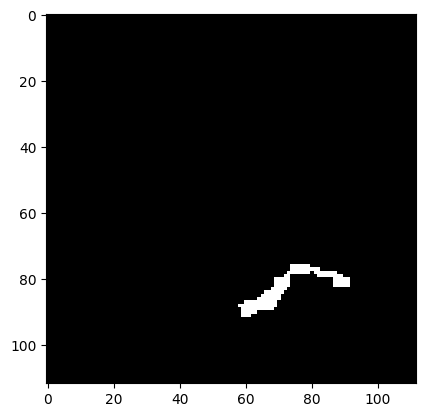

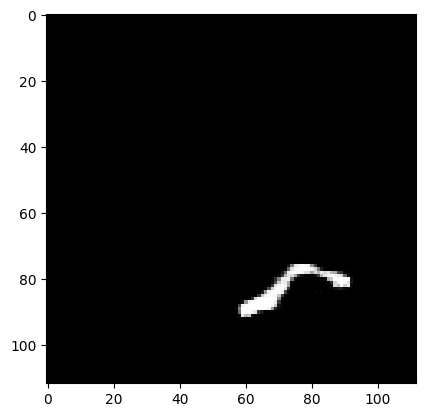

In [21]:
plt.figure()
plt.gray()
plt.imshow(target.squeeze(0).squeeze(0).detach().numpy())

plt.figure()
plt.gray()
plt.imshow(last_output.squeeze(0).squeeze(0).detach().numpy())

## Train UNet on batch

TypeError: list indices must be integers or slices, not str